In [1]:
import subprocess, numpy as np, tifffile, matplotlib.pyplot as plt, os
from skimage.measure import label, regionprops
import joblib as jl
from tqdm.notebook import tqdm

import glob, os, re, shutil, subprocess, pgzip, time, traceback, tifffile, numpy as np, numba as nb, \
    scipy.stats, joblib as jl
from itertools import chain
from skimage.measure import label, regionprops

In [2]:
pts0, pts1 = jl.load('C:/Users/acorver/Desktop/pts0pts1.pickle')

In [3]:
fnameRef = 'D:\\test\\BRAIN019w_ref_pointlabels.tif'
fnameMov = 'D:\\test\\BRAIN016w_mov_pointlabels.tif'

imgRef = tifffile.imread(fnameRef)
imgMov = tifffile.imread(fnameMov)

In [74]:
labels = []
ss = 1
for fnameLabels in [fnameRef, fnameMov]:
    # Load labels
    imgLabels = tifffile.imread(fnameLabels)[::ss, ::ss, ::ss]
    # Find regions
    props = regionprops(imgLabels)
    labelPos = {}
    labelSize = {}
    for prop in tqdm(props, desc='Finding annotation centroids...'):
        if prop.label in labelPos:
            if prop.coords.shape[0] < labelSize[prop.label]:
                continue
        _x, _y, _z = np.mean(prop.coords, axis=0).round().astype(int)
        # _x = float(_x) / imgLabels.shape[0]
        # _y = float(_y) / imgLabels.shape[1]
        # _z = float(_z) / imgLabels.shape[2]
        labelPos[prop.label] = (_x, _y, _z)  # (_z, _x, _y)
        labelSize[prop.label] = prop.label
    labels.append(labelPos)
# Only use indices that exist in both reference and moving
labelIDs = np.intersect1d(list(labels[0].keys()), list(labels[1].keys()))
pts0, pts1 = [], []
for i in labelIDs:
    pts0.append(labels[0][i])
    pts1.append(labels[1][i])
pts0 = np.array(pts0, dtype=np.float64)
pts1 = np.array(pts1, dtype=np.float64)

# Pad 1's
pts0 = np.hstack((pts0, np.ones((pts0.shape[0], 1))))
pts1 = np.hstack((pts1, np.ones((pts1.shape[0], 1))))

def mtxFromCoef(A):
    # Create translation matrix
    mtxTranslation = np.identity(4, dtype=np.float64)
    mtxTranslation[0, 3] = A[0]
    mtxTranslation[1, 3] = A[1]
    mtxTranslation[2, 3] = A[2]

    # Create scaling matrix
    mtxScaling = np.identity(4, dtype=np.float64)
    mtxScaling[0, 0] = A[3]
    mtxScaling[1, 1] = A[4]
    mtxScaling[2, 2] = A[5]

    # Create rotation matrix (X)
    mtxRotation = np.identity(4, dtype=np.float64)
    mtxRotation[:3, :3] = scipy.spatial.transform.Rotation.from_euler('xyz', [
        A[6],
        A[7],
        A[8],
    ]).as_matrix()

    # Return affine matrix
    mtx = mtxRotation @ (mtxScaling @ mtxTranslation)
    return mtx

def _lstsqFit(A):
    mtx = mtxFromCoef(A)
    pts0_ = pts1 @ mtx
    return np.percentile(np.linalg.norm((pts0_ - pts0)[:, 0:3], axis=1), 100)
    #return np.mean(np.linalg.norm(pts0_ - pts0, axis=1))

_x0 = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1])

r = None
for k in tqdm(range(1000)):
    r_ = scipy.optimize.minimize(_lstsqFit,
        x0=_x0 + 2 * np.random.random(size=9), method='Nelder-Mead',
        options={'maxiter': 1000})
    if r is None:
        r = r_
    else:
        if r_.fun < r.fun:
            r = r_
            print(r.fun)

A = mtxFromCoef(r.x)

# Verify transform
print('Error from least-squares affine fit is: {}'.format(np.sum(np.abs((pts1 @ A - pts0)[:, 0:3]))))

imgMovSyn = tifffile.imread(fnameMov.replace('pointlabels', 'synapsin'))
imgMovT = scipy.ndimage.affine_transform(
    imgMovSyn, np.linalg.inv(A), mode='nearest', order=1, output=imgMovSyn.dtype, output_shape=imgRef.shape)
tifffile.imwrite(fnameMov.replace('pointlabels', 'synapsin') + '.transform.tif', imgMovT, bigtiff=True)

Finding annotation centroids...:   0%|          | 0/17 [00:00<?, ?it/s]

Finding annotation centroids...:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

211.91010727287951
133.70380235639755
123.18630727938124
123.1559802560923
Error from least-squares affine fit is: 2308.4536501408998


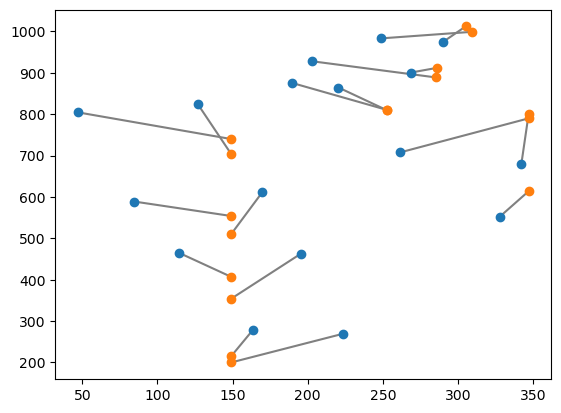

In [117]:
a0, a1 = 0, 1
xyz0 = (pts1 @ A)
xyz1 = pts0
for k in range(xyz0.shape[0]):
    plt.plot([xyz0[k, a0], xyz1[k, a0]], [xyz0[k, a1], xyz1[k, a1]], c='gray', zorder=-10)
plt.scatter(xyz0[:, a0], xyz0[:, a1])
plt.scatter(xyz1[:, a0], xyz1[:, a1])

In [118]:
print(np.linalg.inv(A))

[[ 0.79151231 -0.1291727   0.08784923 -0.56892146]
 [ 0.15215783  0.92995095 -0.00353463 -0.81728835]
 [-0.09941293  0.01978086  0.92478561 -0.30763448]
 [ 0.          0.          0.          1.        ]]


In [41]:
#print(ptsRef, ptsMov, pts1 @ A[:4, :4])

In [9]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
fnameMov = 'Z:\\StandardBrain\\test\\BRAIN020_221117-FMRFamide-DAPI-oil\\synapsin.tif'
fnameRef = 'Z:\\StandardBrain\\test\\BRAIN020w_221117-FMRFamide-DAPI\\synapsin.tif'

In [ ]:
# Load labels
labels = []
for fname in [fnameRef, fnameMov]:
    # Load labels
    fnameLabels = os.path.join(os.path.dirname(fname), 'pointlabels.tif')
    imgLabels = tifffile.imread(fnameLabels)
    # Find regions
    props = regionprops(imgLabels)
    labelPos = {}
    labelSize = {}
    for prop in props:
        if prop.label in labelPos:
            if prop.coords.shape[0] < labelSize[prop.label]:
                continue
        labelPos[prop.label] = np.mean(prop.coords, axis=0).round().astype(int)
        labelSize[prop.label] = prop.label
    labels.append(labelPos)

In [ ]:
# Only use indices that exist in both reference and moving
labelIDs = np.intersect1d(list(labels[0].keys()), list(labels[1].keys()))
labelIDs

In [ ]:
fnamePtsRef = fnameRef.replace('.tif', '') + '.pts'
with open(fnamePtsRef, 'w') as f:
    f.write('index\n{}\n{}'.format(len(
        labelIDs), '\n'.join(['{},{},{}'.format(*labels[0][i]) for i in labelIDs])))
    
fnamePtsMov = fnameMov.replace('.tif', '') + '.pts'
with open(fnamePtsMov, 'w') as f:
    f.write('index\n{}\n{}'.format(len(
        labelIDs), '\n'.join(['{},{},{}'.format(*labels[0][i]) for i in labelIDs])))

In [ ]:
fnameElastix = 'C:\\Users\\acorver\\Documents\\repositories\\spider-anatomy\\elastix_bin\\elastix.exe'

In [ ]:
fnameRefCache = 'Z:\\StandardBrain\\test\\ref_synapsin.isopad.tif'
fnameMovCache = 'Z:\\StandardBrain\\test\\mov_synapsin.isopad.tif'

In [ ]:
fnameRigidCache = None
fnameNonrigidCache = 'Z:\\StandardBrain\\test\\test_pointalign.txt'
dirout = 'Z:\\StandardBrain\\test\\'

In [ ]:
# Invoke elastix
popen = subprocess.Popen([fnameElastix,
     '-f', nameRefCache, '-m', nameMovCache,] + (
    ['-p', fnameRigidCache] if fnameRigidCache is not None else []) + (
    ['-p', fnameNonrigidCache] if fnameNonrigidCache is not None else []) + [
    '-out', dirout, 
    '-fp', 'fixedPointSet.txt', '-mp', 'movingPointSet.txt'], creationflags=subprocess.BELOW_NORMAL_PRIORITY_CLASS)

In [ ]:
-fp fixedPointSet.txt -mp movingPointSet.txt